In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

#### Hemoglobin

In [4]:
# Load D_LABITEMS to verify the correct ITEMIDs
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/D_LABITEMS.csv.gz') as gz_file:
        d_labitems = pd.read_csv(gz_file, compression='gzip')

# Search for Anion Gap
print("\n" + "=" * 80)
print("SEARCHING FOR HEMOGLOBIN IN D_LABITEMS")
print("=" * 80)
anion_gap_items = d_labitems[d_labitems['LABEL'].str.contains('hemoglobin', case=False, na=False)]
print(anion_gap_items[['ITEMID', 'LABEL', 'FLUID', 'CATEGORY']])


SEARCHING FOR HEMOGLOBIN IN D_LABITEMS
     ITEMID                              LABEL  FLUID    CATEGORY
132   50805                  Carboxyhemoglobin  Blood   Blood Gas
138   50811                         Hemoglobin  Blood   Blood Gas
141   50814                      Methemoglobin  Blood   Blood Gas
179   50852                   % Hemoglobin A1c  Blood   Chemistry
182   50855                Absolute Hemoglobin  Blood   Chemistry
538   51212                   Fetal Hemoglobin  Blood  Hematology
548   51222                         Hemoglobin  Blood  Hematology
549   51223                      Hemoglobin A2  Blood  Hematology
550   51224                       Hemoglobin C  Blood  Hematology
551   51225                       Hemoglobin F  Blood  Hematology
611   51285  Reticulocyte, Cellular Hemoglobin  Blood  Hematology


In [6]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

# ============================================================================
# LOAD LABEVENTS DATA
# ============================================================================

# LABEVENTS is also very large, so we'll load in chunks and filter
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/LABEVENTS.csv.gz') as gz_file:
        chunk_iterator = pd.read_csv(gz_file, compression='gzip', chunksize=1_000_000)
        
        # Filter for Hemoglobin ITEMIDs only
        ag_itemids = [50811, 51222] 
        
        ag_chunks = []
        for i, chunk in enumerate(chunk_iterator):
            print(f"Processing LABEVENTS chunk {i+1}...")
            filtered = chunk[chunk['ITEMID'].isin(ag_itemids)]
            if not filtered.empty:
                ag_chunks.append(filtered)
        
        labevents_ag = pd.concat(ag_chunks, ignore_index=True)

print(f"Loaded {len(labevents_ag)} Anion Gap measurements")

Processing LABEVENTS chunk 1...
Processing LABEVENTS chunk 2...
Processing LABEVENTS chunk 3...
Processing LABEVENTS chunk 4...
Processing LABEVENTS chunk 5...
Processing LABEVENTS chunk 6...
Processing LABEVENTS chunk 7...
Processing LABEVENTS chunk 8...
Processing LABEVENTS chunk 9...
Processing LABEVENTS chunk 10...
Processing LABEVENTS chunk 11...
Processing LABEVENTS chunk 12...
Processing LABEVENTS chunk 13...
Processing LABEVENTS chunk 14...
Processing LABEVENTS chunk 15...
Processing LABEVENTS chunk 16...
Processing LABEVENTS chunk 17...
Processing LABEVENTS chunk 18...
Processing LABEVENTS chunk 19...
Processing LABEVENTS chunk 20...
Processing LABEVENTS chunk 21...
Processing LABEVENTS chunk 22...
Processing LABEVENTS chunk 23...
Processing LABEVENTS chunk 24...
Processing LABEVENTS chunk 25...
Processing LABEVENTS chunk 26...
Processing LABEVENTS chunk 27...
Processing LABEVENTS chunk 28...
Loaded 842156 Anion Gap measurements


In [7]:
labevents_ag

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,335,3,NaN,51222,2101-10-14 03:00:00,10.3,10.3,g/dL,abnormal
1,375,3,NaN,51222,2101-10-15 03:30:00,9.9,9.9,g/dL,abnormal
2,410,3,NaN,51222,2101-10-16 04:00:00,10.2,10.2,g/dL,abnormal
3,949,3,145834.0,51222,2101-10-22 04:00:00,9.5,9.5,g/dL,abnormal
4,982,3,145834.0,50811,2101-10-22 04:34:00,8.7,8.7,g/dL,abnormal
...,...,...,...,...,...,...,...,...,...
842151,27764192,98994,178949.0,51222,2137-09-25 04:29:00,8.5,8.5,g/dL,abnormal
842152,27427179,96442,107499.0,51222,2115-05-27 04:47:00,8.1,8.1,g/dL,abnormal
842153,27427206,96442,107499.0,51222,2115-05-28 04:38:00,7.9,7.9,g/dL,abnormal
842154,27427229,96442,120151.0,51222,2115-06-29 04:45:00,9.5,9.5,g/dL,abnormal


In [8]:
labevents_ag['VALUEUOM'].unique()

array(['g/dL', nan], dtype=object)

In [10]:
labevents_ag['FLAG'].value_counts()

FLAG
abnormal    748098
delta         4443
Name: count, dtype: int64

In [11]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Load PATIENTS table
    with zip_ref.open('mimic-iii-clinical-database-1.4/PATIENTS.csv.gz') as gz_file:
        patients = pd.read_csv(gz_file, compression='gzip')
    
    # Load ICUSTAYS table
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')

In [12]:
# Convert datetime columns
labevents_ag['CHARTTIME'] = pd.to_datetime(labevents_ag['CHARTTIME'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])

# Merge with ICUSTAYS to get admission times
labevents_ag_with_time = labevents_ag.merge(
    icustays[['ICUSTAY_ID', 'HADM_ID', 'INTIME']], 
    on=['HADM_ID'], 
    how='inner'
)

# Calculate hours from ICU admission
labevents_ag_with_time['HOURS_FROM_ADMISSION'] = (
    labevents_ag_with_time['CHARTTIME'] - labevents_ag_with_time['INTIME']
).dt.total_seconds() / 3600

# Filter for first 48 hours
labevents_ag_48h = labevents_ag_with_time[
    #(labevents_ag_with_time['HOURS_FROM_ADMISSION'] >= 0) & 
    (labevents_ag_with_time['HOURS_FROM_ADMISSION'] <= 48)
].copy()

In [13]:
hem_itemids = [50811, 51222] 
hem_data = labevents_ag_48h[labevents_ag_48h['ITEMID'].isin(ag_itemids)].copy()

# Clean Anion Gap data
hem_data = hem_data[
    (hem_data['VALUENUM'].notna()) & 
    (hem_data['VALUENUM'] >= 0) & 
    (hem_data['VALUENUM'] <= 25)
]

# Calculate average Hemoglobin per ICU stay
hem_features = hem_data.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()
hem_features.columns = ['ICUSTAY_ID', 'HEM_MEAN', 'HEM_MEDIAN', 'HEM_STD', 'HEM_MIN', 'HEM_MAX', 'HEM_COUNT']

In [14]:
hem_features.head()

,ICUSTAY_ID,HEM_MEAN,HEM_MEDIAN,HEM_STD,HEM_MIN,HEM_MAX,HEM_COUNT
0,200001,8.336364,8.00,0.706078,7.3,9.2,11
1,200003,10.900000,10.80,0.556776,10.4,11.5,3
2,200006,9.925000,9.40,1.586138,8.7,12.2,4
3,200007,13.650000,13.15,1.250333,12.8,15.5,4
4,200009,9.414286,9.15,1.420648,7.0,12.3,14


In [15]:
# Load the df with all derived features until now
features = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser.csv')

In [16]:
features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,SYSBP_MAX,SYSBP_COUNT,DIASBP_MEAN,DIASBP_MEDIAN,DIASBP_STD,DIASBP_MIN,DIASBP_MAX,DIASBP_COUNT,comorbidity_score,age_adj_comorbidity_score
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,162.0,98.0,52.326531,52.0,10.997446,12.0,86.0,98.0,20.0,22.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,126.0,65.0,51.538462,51.0,8.739417,32.0,78.0,65.0,4.0,4.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,163.0,79.0,48.594937,49.0,7.365058,33.0,71.0,79.0,15.0,19.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,197.0,241.0,69.780083,70.0,8.684599,44.0,109.0,241.0,0.0,2.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,180.0,193.0,79.331606,80.0,11.112769,50.0,102.0,193.0,9.0,13.0


In [18]:
# Merge Hemoglobin features to feature df
final_df_with_hem = features.merge(
    hem_features, 
    on='ICUSTAY_ID', 
    how='left'
)

In [19]:
final_df_with_hem.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,DIASBP_MAX,DIASBP_COUNT,comorbidity_score,age_adj_comorbidity_score,HEM_MEAN,HEM_MEDIAN,HEM_STD,HEM_MIN,HEM_MAX,HEM_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,86.0,98.0,20.0,22.0,10.800,10.85,1.087592,9.5,12.8,8.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,78.0,65.0,4.0,4.0,12.220,11.80,1.353514,11.2,14.6,5.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,71.0,79.0,15.0,19.0,14.175,14.10,0.590903,13.6,14.9,4.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,109.0,241.0,0.0,2.0,13.025,12.45,1.252664,12.3,14.9,4.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,102.0,193.0,9.0,13.0,12.900,12.20,2.232487,11.1,17.0,6.0


In [20]:
# Export new feature df as csv
#final_df_with_hem.to_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem.csv', index = False)

#### Urea Nitrogen

In [26]:
# Load D_LABITEMS to verify the correct ITEMIDs
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/D_LABITEMS.csv.gz') as gz_file:
        d_labitems = pd.read_csv(gz_file, compression='gzip')

# Search for Anion Gap
print("\n" + "=" * 80)
print("SEARCHING FOR HEMOGLOBIN IN D_LABITEMS")
print("=" * 80)
anion_gap_items = d_labitems[d_labitems['LABEL'].str.contains('urea', case=False, na=False)]
print(anion_gap_items[['ITEMID', 'LABEL', 'FLUID', 'CATEGORY']])


SEARCHING FOR HEMOGLOBIN IN D_LABITEMS
     ITEMID                      LABEL             FLUID   CATEGORY
178   50851     Urea Nitrogen, Ascites           Ascites  Chemistry
332   51006              Urea Nitrogen             Blood  Chemistry
371   51045  Urea Nitrogen, Body Fluid  Other Body Fluid  Chemistry
430   51104       Urea Nitrogen, Urine             Urine  Chemistry


In [27]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

# ============================================================================
# LOAD LABEVENTS DATA
# ============================================================================

# LABEVENTS is also very large, so we'll load in chunks and filter
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/LABEVENTS.csv.gz') as gz_file:
        chunk_iterator = pd.read_csv(gz_file, compression='gzip', chunksize=1_000_000)
        
        # Filter for Urea Nitrogen ITEMIDs only
        ag_itemids = [51006] 
        
        ag_chunks = []
        for i, chunk in enumerate(chunk_iterator):
            print(f"Processing LABEVENTS chunk {i+1}...")
            filtered = chunk[chunk['ITEMID'].isin(ag_itemids)]
            if not filtered.empty:
                ag_chunks.append(filtered)
        
        labevents_ag = pd.concat(ag_chunks, ignore_index=True)

print(f"Loaded {len(labevents_ag)} Anion Gap measurements")

Processing LABEVENTS chunk 1...
Processing LABEVENTS chunk 2...
Processing LABEVENTS chunk 3...
Processing LABEVENTS chunk 4...
Processing LABEVENTS chunk 5...
Processing LABEVENTS chunk 6...
Processing LABEVENTS chunk 7...
Processing LABEVENTS chunk 8...
Processing LABEVENTS chunk 9...
Processing LABEVENTS chunk 10...
Processing LABEVENTS chunk 11...
Processing LABEVENTS chunk 12...
Processing LABEVENTS chunk 13...
Processing LABEVENTS chunk 14...
Processing LABEVENTS chunk 15...
Processing LABEVENTS chunk 16...
Processing LABEVENTS chunk 17...
Processing LABEVENTS chunk 18...
Processing LABEVENTS chunk 19...
Processing LABEVENTS chunk 20...
Processing LABEVENTS chunk 21...
Processing LABEVENTS chunk 22...
Processing LABEVENTS chunk 23...
Processing LABEVENTS chunk 24...
Processing LABEVENTS chunk 25...
Processing LABEVENTS chunk 26...
Processing LABEVENTS chunk 27...
Processing LABEVENTS chunk 28...
Loaded 791838 Anion Gap measurements


In [28]:
labevents_ag['VALUEUOM'].unique()

array(['mg/dL', nan], dtype=object)

In [29]:
labevents_ag['FLAG'].value_counts()

FLAG
abnormal    442789
Name: count, dtype: int64

In [31]:
# Convert datetime columns
labevents_ag['CHARTTIME'] = pd.to_datetime(labevents_ag['CHARTTIME'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])

# Merge with ICUSTAYS to get admission times
labevents_ag_with_time = labevents_ag.merge(
    icustays[['ICUSTAY_ID', 'HADM_ID', 'INTIME']], 
    on=['HADM_ID'], 
    how='inner'
)

# Calculate hours from ICU admission
labevents_ag_with_time['HOURS_FROM_ADMISSION'] = (
    labevents_ag_with_time['CHARTTIME'] - labevents_ag_with_time['INTIME']
).dt.total_seconds() / 3600

# Filter for first 48 hours
labevents_ag_48h = labevents_ag_with_time[
    #(labevents_ag_with_time['HOURS_FROM_ADMISSION'] >= 0) & 
    (labevents_ag_with_time['HOURS_FROM_ADMISSION'] <= 48)
].copy()

In [65]:
urea_itemids = [51006] 
urea_data = labevents_ag_48h[labevents_ag_48h['ITEMID'].isin(ag_itemids)].copy()

# Clean Anion Gap data
urea_data = urea_data[
    (urea_data['VALUENUM'].notna()) & 
    (urea_data['VALUENUM'] >= 0) & 
    (urea_data['VALUENUM'] <= 300)
]

# Calculate average Hemoglobin per ICU stay
urea_features = urea_data.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()
urea_features.columns = ['ICUSTAY_ID', 'UREA_MEAN', 'UREA_MEDIAN', 'UREA_STD', 'UREA_MIN', 'UREA_MAX', 'UREA_COUNT']

In [66]:
urea_features.head()

,ICUSTAY_ID,UREA_MEAN,UREA_MEDIAN,UREA_STD,UREA_MIN,UREA_MAX,UREA_COUNT
0,200001,52.900000,46.0,21.434396,32.0,96.0,10
1,200003,20.250000,20.5,0.957427,19.0,21.0,4
2,200006,12.666667,13.0,1.527525,11.0,14.0,3
3,200007,10.000000,9.5,2.160247,8.0,13.0,4
4,200009,17.333333,16.0,3.214550,15.0,21.0,3


In [67]:
features = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem.csv')

features.head(6)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,DIASBP_MAX,DIASBP_COUNT,comorbidity_score,age_adj_comorbidity_score,HEM_MEAN,HEM_MEDIAN,HEM_STD,HEM_MIN,HEM_MAX,HEM_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,86.0,98.0,20.0,22.0,10.800000,10.85,1.087592,9.5,12.8,8.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,78.0,65.0,4.0,4.0,12.220000,11.80,1.353514,11.2,14.6,5.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,71.0,79.0,15.0,19.0,14.175000,14.10,0.590903,13.6,14.9,4.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,109.0,241.0,0.0,2.0,13.025000,12.45,1.252664,12.3,14.9,4.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,102.0,193.0,9.0,13.0,12.900000,12.20,2.232487,11.1,17.0,6.0
5,279,192224,204407,0,81.333333,82.0,7.944681,62.0,96.0,66.0,...,71.0,103.0,20.0,23.0,11.472727,11.70,1.316124,9.8,13.7,11.0


In [68]:
# Merge Hemoglobin features to feature df
final_df_with_urea = features.merge(
    urea_features, 
    on='ICUSTAY_ID', 
    how='left'
)

In [69]:
final_df_with_urea.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,HEM_STD,HEM_MIN,HEM_MAX,HEM_COUNT,UREA_MEAN,UREA_MEDIAN,UREA_STD,UREA_MIN,UREA_MAX,UREA_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,1.087592,9.5,12.8,8.0,57.20,61.0,17.725061,24.0,83.0,10.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,1.353514,11.2,14.6,5.0,8.00,8.0,1.897367,6.0,11.0,6.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,0.590903,13.6,14.9,4.0,28.00,28.5,1.414214,26.0,29.0,4.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,1.252664,12.3,14.9,4.0,12.25,11.5,2.629956,10.0,16.0,4.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,2.232487,11.1,17.0,6.0,32.00,28.0,9.695360,24.0,49.0,6.0


In [70]:
# Export new feature df as csv
#final_df_with_urea.to_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea.csv', index = False)

In [71]:
df = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea.csv')

df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,HEM_STD,HEM_MIN,HEM_MAX,HEM_COUNT,UREA_MEAN,UREA_MEDIAN,UREA_STD,UREA_MIN,UREA_MAX,UREA_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,1.087592,9.5,12.8,8.0,57.20,61.0,17.725061,24.0,83.0,10.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,1.353514,11.2,14.6,5.0,8.00,8.0,1.897367,6.0,11.0,6.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,0.590903,13.6,14.9,4.0,28.00,28.5,1.414214,26.0,29.0,4.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,1.252664,12.3,14.9,4.0,12.25,11.5,2.629956,10.0,16.0,4.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,2.232487,11.1,17.0,6.0,32.00,28.0,9.695360,24.0,49.0,6.0


Correlation with MORTALITY_INHOSPITAL:
 MORTALITY_INHOSPITAL         1.000000
age_adj_comorbidity_score    0.214751
comorbidity_score            0.206490
AG_MEAN                      0.204531
AG_MEDIAN                    0.203589
AG_MAX                       0.180133
UREA_MAX                     0.176772
UREA_MEAN                    0.176580
UREA_MIN                     0.173704
UREA_MEDIAN                  0.173260
SYSBP_STD                    0.169159
AG_MIN                       0.157463
RR_MEAN                      0.142402
RR_MEDIAN                    0.134513
TEMP_STD                     0.127002
HR_MAX                       0.115573
AGE                          0.114018
RR_MAX                       0.098224
HR_STD                       0.093442
HR_MEAN                      0.091811
RR_MIN                       0.086036
HR_MEDIAN                    0.084977
UREA_STD                     0.075595
DIASBP_STD                   0.064822
AG_STD                       0.053301
SYSBP_MAX 

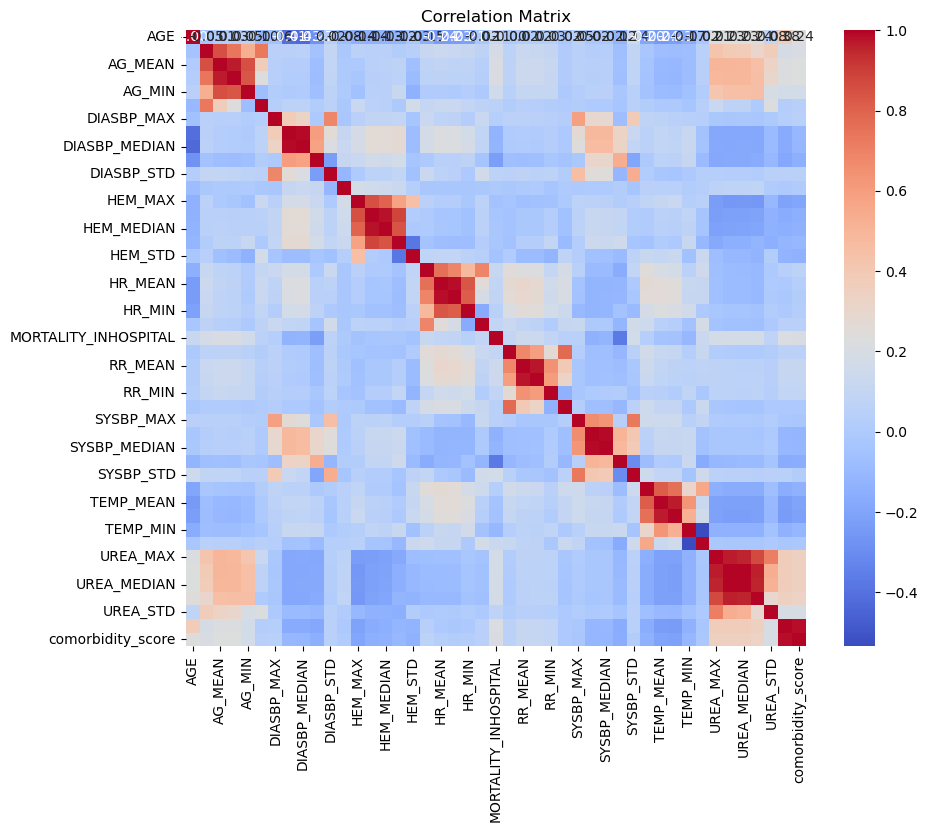

In [72]:
df_corr = df.copy()

numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# Exclude columns
id_cols = ['SUBJECT_ID', 'ICUSTAY_ID', 'HADM_ID', 'HR_COUNT', 'SYSBP_COUNT', 'DIASBP_COUNT', 'TEMP_COUNT', 'AG_COUNT', 'RR_COUNT', 'HEM_COUNT', 'UREA_COUNT']
numeric_cols = [col for col in numeric_cols if col not in id_cols]

# Sort alphabetically
numeric_cols = sorted(numeric_cols)

df_numeric = df_corr[numeric_cols]
corr_matrix = df_numeric.corr()

# Show correlation of features with target
target_corr = corr_matrix['MORTALITY_INHOSPITAL'].sort_values(ascending=False)
print("Correlation with MORTALITY_INHOSPITAL:\n", target_corr)

# Optional: Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Conclusion:
- Hemoglobin (HEM) features are not useful because of their low correlation 
- Urea Nitrogen (Urea) features are useful since their correlation with target variable is ~0.17

